In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torchvision
import transformers

device = torch.device("cuda")

#image_processor = transformers.AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_processor = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #lambda x: x / 255,
])
model = transformers.ResNetModel.from_pretrained("microsoft/resnet-50").to(device)

In [2]:
for name, param in model.named_parameters():
    print(name)

embedder.embedder.convolution.weight
embedder.embedder.normalization.weight
embedder.embedder.normalization.bias
encoder.stages.0.layers.0.shortcut.convolution.weight
encoder.stages.0.layers.0.shortcut.normalization.weight
encoder.stages.0.layers.0.shortcut.normalization.bias
encoder.stages.0.layers.0.layer.0.convolution.weight
encoder.stages.0.layers.0.layer.0.normalization.weight
encoder.stages.0.layers.0.layer.0.normalization.bias
encoder.stages.0.layers.0.layer.1.convolution.weight
encoder.stages.0.layers.0.layer.1.normalization.weight
encoder.stages.0.layers.0.layer.1.normalization.bias
encoder.stages.0.layers.0.layer.2.convolution.weight
encoder.stages.0.layers.0.layer.2.normalization.weight
encoder.stages.0.layers.0.layer.2.normalization.bias
encoder.stages.0.layers.1.layer.0.convolution.weight
encoder.stages.0.layers.1.layer.0.normalization.weight
encoder.stages.0.layers.1.layer.0.normalization.bias
encoder.stages.0.layers.1.layer.1.convolution.weight
encoder.stages.0.layers.1.

In [3]:
def content_loss(a, b):
    diff2 = (a - b)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2

def gram(layer):
    shape = layer.shape
    features = layer.reshape((shape[0], shape[1], shape[2] * shape[3]))
    g = torch.matmul(features, features.transpose(1, 2))
    return g

def style_loss(a, b):
    a_gram, b_gram = gram(a), gram(b)
    diff2 = (a_gram - b_gram)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2 / a.shape[1] / a.shape[2] / a.shape[3]

In [4]:
a = torch.tensor(
    [[
        [
            [1, 2, 3],
            [2, 1, 0],
            [-1, 2, -4],
        ],
        [
            [1, 2, 3],
            [2, 1, 0],
            [-1, 2, -4],
        ]
    ]]
)

print(gram(a))

tensor([[[40, 40],
         [40, 40]]])


In [5]:
a = torch.tensor(
    [[
        [
            [1, 2, 3],
            [2, 1, 0],
            [-1, 2, -4],
        ],
        [
            [-1, 2, -1],
            [2, 1, 0],
            [1, 2, 4],
        ]
    ]]
)

print(gram(a))

tensor([[[40, -8],
         [-8, 32]]])


In [6]:
def analyse_images(path1, path2):
    img1 = PIL.Image.open(path1)
    img2 = PIL.Image.open(path2)
    print(img2.size)

    img1_inputs = image_processor(img1).unsqueeze(0).to(device)
    print(img1_inputs)
    print(torch.min(img1_inputs), torch.mean(img1_inputs), torch.max(img1_inputs))
    img2_inputs = image_processor(img2).unsqueeze(0).to(device)
    plt.imshow(img1_inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()
    plt.imshow(img2_inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()
    print(img1_inputs.shape)
    with torch.no_grad():
        img1_outputs = model(img1_inputs, output_hidden_states = True)
        img2_outputs = model(img2_inputs, output_hidden_states = True)

    for img1_state, img2_state in zip(img1_outputs.hidden_states, img2_outputs.hidden_states):
        print(img1_state.shape)
        print(content_loss(img1_state, img2_state))
        print(style_loss(img1_state, img2_state))
        print("")    

(258, 196)
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')
tensor(0., device='cuda:0') tensor(0.7818, device='cuda:0') tensor(1., device='cuda:0')


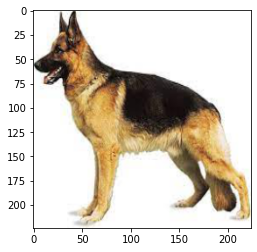

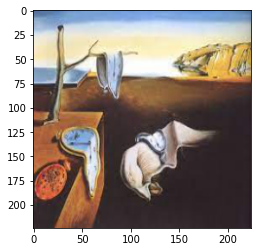

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 56, 56])
tensor(90005.2109, device='cuda:0')
tensor(2640351.5000, device='cuda:0')

torch.Size([1, 256, 56, 56])
tensor(72242.7422, device='cuda:0')
tensor(5754.4253, device='cuda:0')

torch.Size([1, 512, 28, 28])
tensor(807119., device='cuda:0')
tensor(808570.6875, device='cuda:0')

torch.Size([1, 1024, 14, 14])
tensor(318789.5000, device='cuda:0')
tensor(94910.4922, device='cuda:0')

torch.Size([1, 2048, 7, 7])
tensor(11003.2236, device='cuda:0')
tensor(205.5191, device='cuda:0')



In [7]:
analyse_images("dog6.jpeg", "time2.jpeg")

(258, 196)
tensor([[[[0.1216, 0.1216, 0.1216,  ..., 0.0902, 0.0902, 0.0902],
          [0.1216, 0.1216, 0.1216,  ..., 0.0902, 0.0902, 0.0902],
          [0.1255, 0.1255, 0.1255,  ..., 0.0902, 0.0941, 0.0941],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.0941, 0.0941, 0.0941],
          [0.1176, 0.1176, 0.1176,  ..., 0.0902, 0.0902, 0.0902],
          [0.1176, 0.1176, 0.1176,  ..., 0.0902, 0.0902, 0.0902]],

         [[0.1216, 0.1216, 0.1216,  ..., 0.0941, 0.0941, 0.0941],
          [0.1216, 0.1216, 0.1216,  ..., 0.0980, 0.0941, 0.0941],
          [0.1255, 0.1255, 0.1255,  ..., 0.1020, 0.0980, 0.0980],
          ...,
          [0.1412, 0.1412, 0.1412,  ..., 0.1216, 0.1255, 0.1255],
          [0.1451, 0.1451, 0.1451,  ..., 0.1216, 0.1216, 0.1216],
          [0.1451, 0.1451, 0.1451,  ..., 0.1216, 0.1216, 0.1216]],

         [[0.1686, 0.1686, 0.1686,  ..., 0.1137, 0.1137, 0.1137],
          [0.1686, 0.1686, 0.1686,  ..., 0.1176, 0.1137, 0.1137],
          [0.1725, 0.1725, 0.17

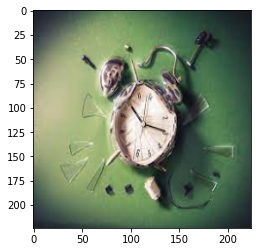

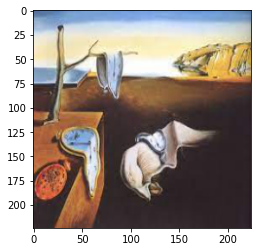

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 56, 56])
tensor(42113.9531, device='cuda:0')
tensor(107281.0156, device='cuda:0')

torch.Size([1, 256, 56, 56])
tensor(67587.6953, device='cuda:0')
tensor(4921.0059, device='cuda:0')

torch.Size([1, 512, 28, 28])
tensor(654005.1250, device='cuda:0')
tensor(371946.9688, device='cuda:0')

torch.Size([1, 1024, 14, 14])
tensor(288386.5000, device='cuda:0')
tensor(101503.7734, device='cuda:0')

torch.Size([1, 2048, 7, 7])
tensor(10346.5547, device='cuda:0')
tensor(171.7703, device='cuda:0')



In [8]:
analyse_images("time.jpeg", "time2.jpeg")

In [9]:
for name, param in model.named_parameters():
    print(name)

embedder.embedder.convolution.weight
embedder.embedder.normalization.weight
embedder.embedder.normalization.bias
encoder.stages.0.layers.0.shortcut.convolution.weight
encoder.stages.0.layers.0.shortcut.normalization.weight
encoder.stages.0.layers.0.shortcut.normalization.bias
encoder.stages.0.layers.0.layer.0.convolution.weight
encoder.stages.0.layers.0.layer.0.normalization.weight
encoder.stages.0.layers.0.layer.0.normalization.bias
encoder.stages.0.layers.0.layer.1.convolution.weight
encoder.stages.0.layers.0.layer.1.normalization.weight
encoder.stages.0.layers.0.layer.1.normalization.bias
encoder.stages.0.layers.0.layer.2.convolution.weight
encoder.stages.0.layers.0.layer.2.normalization.weight
encoder.stages.0.layers.0.layer.2.normalization.bias
encoder.stages.0.layers.1.layer.0.convolution.weight
encoder.stages.0.layers.1.layer.0.normalization.weight
encoder.stages.0.layers.1.layer.0.normalization.bias
encoder.stages.0.layers.1.layer.1.convolution.weight
encoder.stages.0.layers.1.